# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## Importing Liberaries

In [1]:
import numpy as np
import os
# from scipy.misc import imread, imresize
from skimage import io
from skimage.io import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM
#write your model here
import cv2

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

Creating a function for creating plots for model results

In [5]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
project_folder='datasets/Project_data/'
curr_dt_time = datetime.datetime.now()
train_doc = np.random.permutation(open(project_folder + 'train.csv').readlines())
val_doc = np.random.permutation(open(project_folder + 'val.csv').readlines())
train_path = project_folder + 'train'
val_path = project_folder + 'val'
print('train_length=', len(train_doc))
print('val_length=', len(val_doc))
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

train_length= 663
val_length= 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def generator(source_path, folder_list,batch_size, total_frames, frames_to_sample, image_height, image_width,augment=False,):
  img_idx = np.round(np.linspace(0, total_frames-1, frames_to_sample)).astype(int)
  while True:
    t = np.random.permutation(folder_list)
    num_batches = len(t) // batch_size

    for batch in range(num_batches):
      batch_data, batch_labels = single_batch_data(source_path, t, batch, batch_size, img_idx, augment, image_height, image_width)
      yield batch_data, batch_labels

    remaining_seq = len(t) % batch_size

    if (remaining_seq != 0):
      batch_data, batch_labels = single_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, image_height, image_width, remaining_seq)
      yield batch_data, batch_labels


In [8]:
    def single_batch_data(source_path,t,batch,batch_size,img_idx,augment, image_height,image_width,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),image_height,image_width,3)) #channels=3
        batch_labels = np.zeros((seq_len,5)) #since num_classes = 5
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),image_height,image_width,3))
        #introducing augmentation of the data to increqase accuacy and avoid overfitting
        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):

                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(image_height,image_width,3))#resizing the image to dynamic height, width

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted_image = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    #applies an affine transformation to the image
                    gray = cv2.cvtColor(shifted_image,cv2.COLOR_BGR2GRAY)#shifted image is converted to grayscale format

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    #These pixels represent the area where the gesture likely exists, where pixel value is >0
                    
                    cropped=shifted_image[x0:x1,y0:y1,:]#cropping to remove the noise
                    
                    image_resized=resize(cropped,(image_height,image_width,3))
                    
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
            # concatenating the augmented image and returning both orginal and augmented image.
        
        return(batch_data,batch_labels)

## Creating functions for compiling and training the model

In [9]:
def compile_model(model, optimiser = 'adam'):
    optimiser = Adam()
    model.compile(optimizer=optimiser,  loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.summary()
    return model

def train_model(model,  batch_size, total_frames, frames_to_sample,image_height,image_width, num_epochs,augment_data=False,):
        train_generator = generator(train_path, train_doc,augment=augment_data, batch_size=batch_size, total_frames=total_frames, frames_to_sample=frames_to_sample,image_height=image_height,image_width=image_width)
        val_generator = generator(val_path, val_doc,batch_size=batch_size, total_frames=total_frames, frames_to_sample=frames_to_sample,image_height=image_height,image_width=image_width)

        # augmentation is enabled only for train data and not for validation data.
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

Created a custom generator, compile and train helper functions that can be used for all the models.

## Model
Since video is a sequence of images we need to use Conv3D to train it, instead of Conv2D. So lets try to create an simple model to test wheather its working or not - for sample/ ablation experiment

### Conv3d - Experiment 1 - Ablation model

In [20]:
def ablation_model(frames_to_sample,image_height, image_width ):
        model = Sequential()
        model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same',
        input_shape=(frames_to_sample,image_height,image_width,3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(5,activation='softmax'))

        return model

In [18]:
image_height = 160
image_width = 160
channels=3
num_classes=5
total_frames=30
frames_to_sample=15
batch_size=20
num_epochs=2

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 15, 160, 160, 16)  1312      
                                                                 
 activation_10 (Activation)  (None, 15, 160, 160, 16)  0         
                                                                 
 batch_normalization_14 (Bat  (None, 15, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 7, 80, 80, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_11 (Conv3D)          (None, 7, 80, 80, 32)     4128      
                                                                 
 activation_11 (Activation)  (None, 7, 80, 80, 32)    

/tmp/ipykernel_261/81854442.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/2


2024-07-02 16:55:50.277022: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.7057 - categorical_accuracy: 0.4118
Epoch 00001: val_loss improved from inf to 4.52191, saving model to model_init_2024-07-0216_55_45.610198/model-00001-1.70565-0.41176-4.52191-0.21000.h5
34/34 [==============================] - 90s 3s/step - loss: 1.7057 - categorical_accuracy: 0.4118 - val_loss: 4.5219 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
34/34 [==============================] - ETA: 0s - loss: 1.0819 - categorical_accuracy: 0.5807
Epoch 00002: val_loss did not improve from 4.52191
34/34 [==============================] - 86s 3s/step - loss: 1.0819 - categorical_accuracy: 0.5807 - val_loss: 10.3720 - val_categorical_accuracy: 0.2400 - lr: 0.0010


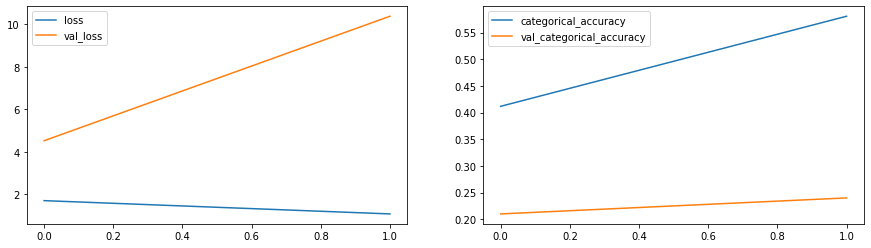

In [25]:
# running only for 2 epochs
ablation_model1 = ablation_model(frames_to_sample = 15,image_height=160, image_width=160)
model = compile_model(ablation_model1,optimiser="adam")
ablation_history = train_model(ablation_model1,  batch_size, total_frames, frames_to_sample,image_height,image_width, num_epochs,augment_data=False)
plot(ablation_history)

In [26]:
ablation_model1.output_shape

(None, 5)

The model seems fine and ran without any errors. Now lets try with more number of epochs and tune different hyperparameters to check the performance. 

### Conv3d - Experiment 2 - without augmentation

In [9]:
   def Model_3D_1(filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(frames_to_sample,image_height,image_width,3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(5,activation='softmax'))
        return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_13 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_19 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_14 (Activation)  (None, 10, 80, 80, 32)   

/tmp/ipykernel_261/81854442.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.6054 - categorical_accuracy: 0.4329
Epoch 00001: val_loss improved from inf to 1.54448, saving model to model_init_2024-07-0216_58_59.013544/model-00001-1.60543-0.43288-1.54448-0.32000.h5
17/17 [==============================] - 119s 7s/step - loss: 1.6054 - categorical_accuracy: 0.4329 - val_loss: 1.5445 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.0976 - categorical_accuracy: 0.5837
Epoch 00002: val_loss did not improve from 1.54448
17/17 [==============================] - 117s 7s/step - loss: 1.0976 - categorical_accuracy: 0.5837 - val_loss: 2.0771 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.8012 - categorical_accuracy: 0.6817
Epoch 00003: val_loss did not improve from 1.54448
17/17 [==============================] - 118s 7s/step - loss: 0.8012 - categorical_accuracy: 0

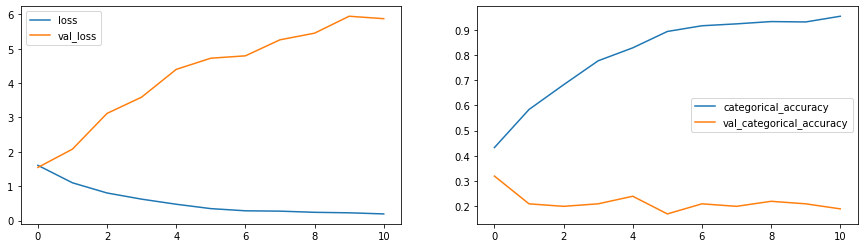

In [28]:
image_height = 160
image_width = 160
channels=3
num_classes=5
total_frames=30
frames_to_sample=20
batch_size=40
num_epochs=15

cnn_3d_model1 = Model_3D_1()
model = compile_model(cnn_3d_model1,optimiser="adam")
cnn_3d_model1_history = train_model(cnn_3d_model1, batch_size, total_frames, frames_to_sample,image_height,image_width, num_epochs, augment_data=False)
plot(cnn_3d_model1_history)# augmentation not enabled

As we can see the categorical accuracy is good but the validation accuracy is very low indicating that model is overfitting.

Also we reached resource exhausation with bqatch size 40 with 20 epocha, so decreasing the batch sie and trying with augmentated data now.

### Conv3d - Experiment 3 - batch size=20 with augmentation

In [34]:
batch_size=20

/tmp/ipykernel_261/81854442.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 0.5519 - categorical_accuracy: 0.8009
Epoch 00001: val_loss improved from inf to 5.96230, saving model to model_init_2024-07-0217_31_56.776275/model-00001-0.55189-0.80090-5.96230-0.21000.h5
34/34 [==============================] - 233s 7s/step - loss: 0.5519 - categorical_accuracy: 0.8009 - val_loss: 5.9623 - val_categorical_accuracy: 0.2100 - lr: 4.0000e-05
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 0.4689 - categorical_accuracy: 0.8303
Epoch 00002: val_loss did not improve from 5.96230
34/34 [==============================] - 233s 7s/step - loss: 0.4689 - categorical_accuracy: 0.8303 - val_loss: 6.2367 - val_categorical_accuracy: 0.2000 - lr: 4.0000e-05
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.4357 - categorical_accuracy: 0.8544
Epoch 00003: val_loss did not improve from 5.96230
34/34 [==============================] - 230s 7s/step - loss: 0.4357 - categorical_acc

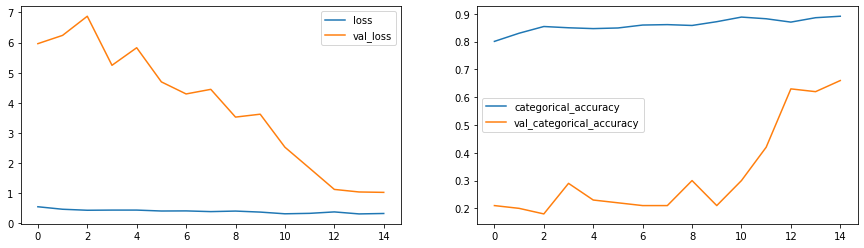

In [35]:
cnn_3d_model2_history = train_model(cnn_3d_model1, batch_size, total_frames, frames_to_sample,image_height,image_width, num_epochs, augment_data=True)
plot(cnn_3d_model2_history)

We can see that the validation accuracy increased significantly once augmentation is enabled.

### Conv3d - Experiment 4

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_17 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_17 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_25 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_18 (Activation)  (None, 8, 60, 60, 32)    

/tmp/ipykernel_261/81854442.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6513 - categorical_accuracy: 0.3906
Epoch 00001: val_loss improved from inf to 1.78454, saving model to model_init_2024-07-0218_35_44.927073/model-00001-1.65131-0.39065-1.78454-0.21000.h5
34/34 [==============================] - 163s 5s/step - loss: 1.6513 - categorical_accuracy: 0.3906 - val_loss: 1.7845 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2003 - categorical_accuracy: 0.5362
Epoch 00002: val_loss did not improve from 1.78454
34/34 [==============================] - 160s 5s/step - loss: 1.2003 - categorical_accuracy: 0.5362 - val_loss: 2.1927 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9530 - categorical_accuracy: 0.6486
Epoch 00003: val_loss did not improve from 1.78454
34/34 [==============================] - 161s 5s/step - loss: 0.9530 - categorical_acc

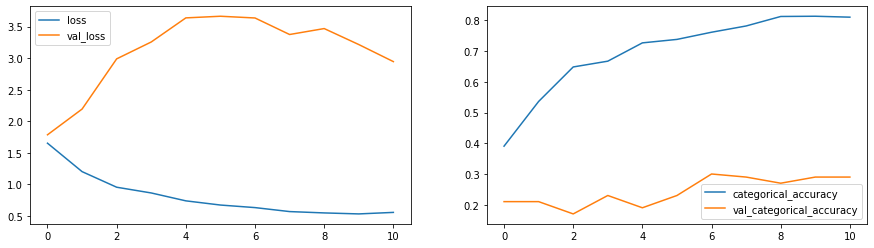

In [36]:
image_height = 120
image_width = 120
channels=3
num_classes=5
total_frames=30
frames_to_sample=16
batch_size=20
num_epochs=20


cnn_3d_model2 = Model_3D_1()
optimiser = Adam(learning_rate=0.0002)
cnn_3d_model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn_3d_model2.summary())
cnn_3d_model3_history = train_model(cnn_3d_model2, batch_size, total_frames, frames_to_sample,image_height,image_width, num_epochs, augment_data=True)
plot(cnn_3d_model3_history)

Now let us try to tune learning rate to (0.0002) and check the performance. As we can see learning rate did not improve the model.

Let us change the image size and increase dense neurons

### Architecture - Conv3d - Experiment 5

2024-07-02 20:46:39.111862: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-07-02 20:46:39.111939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 10, 80, 80, 32)    0

/tmp/ipykernel_206/81854442.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20


2024-07-02 20:46:47.916666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.8765 - categorical_accuracy: 0.4005
Epoch 00001: val_loss improved from inf to 2.75865, saving model to model_init_2024-07-0220_46_39.353645/model-00001-1.87649-0.40045-2.75865-0.21000.h5
34/34 [==============================] - 237s 7s/step - loss: 1.8765 - categorical_accuracy: 0.4005 - val_loss: 2.7586 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4563 - categorical_accuracy: 0.4932
Epoch 00002: val_loss did not improve from 2.75865
34/34 [==============================] - 223s 7s/step - loss: 1.4563 - categorical_accuracy: 0.4932 - val_loss: 4.5371 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1805 - categorical_accuracy: 0.6071
Epoch 00003: val_loss did not improve from 2.75865
34/34 [==============================] - 220s 7s/step - loss: 1.1805 - categorical_accuracy: 0.60

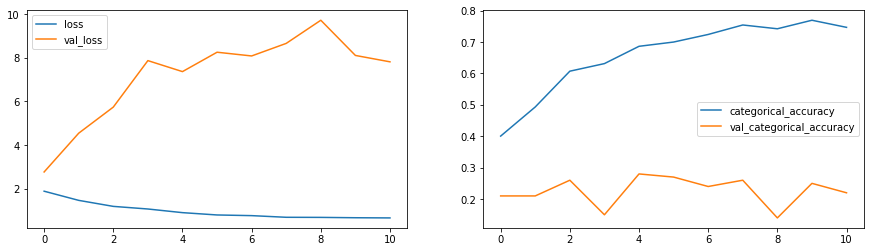

In [10]:
image_height = 160
image_width = 160
channels=3
num_classes=5
total_frames=30
frames_to_sample=20
batch_size=20
num_epochs=20

#Total Params: 3638981
cnn_3d_model3 = Model_3D_1(dense_neurons=256,dropout=0.5)
optimiser = Adam(learning_rate=0.0002)
cnn_3d_model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn_3d_model3.summary())
cnn_3d_model4_history = train_model(cnn_3d_model3,  batch_size, total_frames, frames_to_sample,image_height,image_width, num_epochs,augment_data=True)
plot(cnn_3d_model4_history)

### Conv3d - Experiment 6

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  400       
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 8, 60, 60, 32)    

/tmp/ipykernel_206/81854442.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.1730 - categorical_accuracy: 0.3243
Epoch 00001: val_loss improved from inf to 1.74093, saving model to model_init_2024-07-0221_27_08.566306/model-00001-2.17300-0.32428-1.74093-0.21000.h5
23/23 [==============================] - 156s 7s/step - loss: 2.1730 - categorical_accuracy: 0.3243 - val_loss: 1.7409 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.4497 - categorical_accuracy: 0.5158
Epoch 00002: val_loss did not improve from 1.74093
23/23 [==============================] - 152s 7s/step - loss: 1.4497 - categorical_accuracy: 0.5158 - val_loss: 2.7105 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.3206 - categorical_accuracy: 0.5354
Epoch 00003: val_loss did not improve from 1.74093
23/23 [==============================] - 151s 7s/step - loss: 1.3206 - categorical_acc

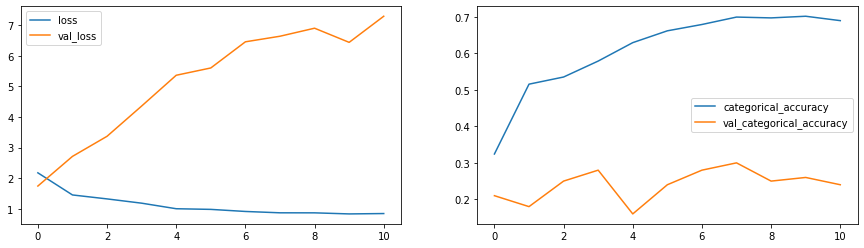

In [11]:
image_height = 120
image_width = 120
channels=3
num_classes=5
total_frames=30
frames_to_sample=16
batch_size=30
num_epochs=25

#Total Params: 3638981
cnn_3d_model4 = Model_3D_1(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
optimiser = Adam(learning_rate=0.0002)
cnn_3d_model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn_3d_model4.summary())
cnn_3d_model5_history = train_model(cnn_3d_model4, batch_size, total_frames, frames_to_sample,image_height,image_width, num_epochs, augment_data=True)
plot(cnn_3d_model5_history)

### Conv2d + LSTM - Experiment 7

Lets try LSTM and GRU models now!

In [12]:
def cnn2d_lstm_model(lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(frames_to_sample,image_height,image_width,3)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))
        
        return model

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_206/81854442.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 60, 60, 32)  

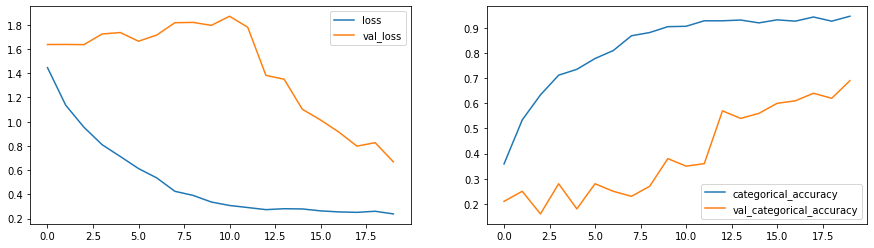

In [13]:
image_height = 120
image_width = 120
channels=3
num_classes=5
total_frames=30
frames_to_sample=15
batch_size=20
num_epochs=20

cnn2d_lstm_model1 = cnn2d_lstm_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
optimiser = Adam(lr=0.0002)
cnn2d_lstm_model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn2d_lstm_model1.summary())
cnn2d_lstm_model1_history = train_model(cnn2d_lstm_model1, batch_size, total_frames, frames_to_sample,image_height,image_width, num_epochs, augment_data=True)
plot(cnn2d_lstm_model1_history)

After using LSTM the validation accuracy improved and it is the best accuracy so far.

### Conv2d + GRU - Experiment 8

In [14]:
def cnn2d_gru_model(gru_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(frames_to_sample,image_height,image_width,3)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))

        return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 60, 60, 32)  

/tmp/ipykernel_206/81854442.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4059 - categorical_accuracy: 0.4133
Epoch 00001: val_loss improved from inf to 1.71653, saving model to model_init_2024-07-0222_44_05.830698/model-00001-1.40591-0.41327-1.71653-0.18000.h5
34/34 [==============================] - 149s 4s/step - loss: 1.4059 - categorical_accuracy: 0.4133 - val_loss: 1.7165 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9702 - categorical_accuracy: 0.6237
Epoch 00002: val_loss did not improve from 1.71653
34/34 [==============================] - 145s 4s/step - loss: 0.9702 - categorical_accuracy: 0.6237 - val_loss: 1.9173 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7431 - categorical_accuracy: 0.7315
Epoch 00003: val_loss did not improve from 1.71653
34/34 [==============================] - 147s 4s/step - loss: 0.7431 - categorical_acc

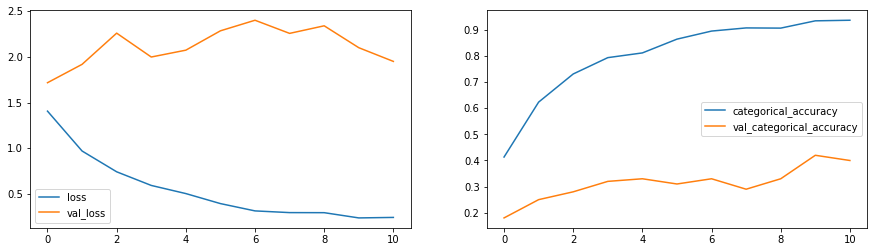

In [15]:
image_height = 120
image_width = 120
channels=3
num_classes=5
total_frames=30
frames_to_sample=15
batch_size=20
num_epochs=20

cnn2d_gru_model1 = cnn2d_gru_model(gru_cells=128,dense_neurons=128,dropout=0.25)
optimiser = Adam(lr=0.0002)
cnn2d_gru_model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn2d_gru_model1.summary())
cnn2d_gru_model1_history = train_model(cnn2d_gru_model1, batch_size, total_frames, frames_to_sample,image_height,image_width, num_epochs, augment_data=True)
plot(cnn2d_gru_model1_history)

Lets try to apply transfer learning. Since mobilenet is not a heavy architecture like vggnet, alexnet it is suitable to use in this case.

### MobileNet + LSTM - Experiment 9

In [10]:
from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
mobilenet_transfer.trainable = False

2024-07-03 01:02:23.396115: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-07-03 01:02:23.396175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


In [19]:
def transfer_learning_model_1(lstm_cells=64, dense_neurons=64, dropout=0.25):

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer, input_shape=(frames_to_sample, image_height, image_width, 3)))

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(lstm_cells))
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(5, activation='softmax'))

    return model  # Add a return statement to return the created model


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 15, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 15, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)              

/tmp/ipykernel_206/81854442.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3503 - categorical_accuracy: 0.4389
Epoch 00001: val_loss improved from inf to 0.95488, saving model to model_init_2024-07-0300_03_00.948874/model-00001-1.35035-0.43891-0.95488-0.59000.h5
34/34 [==============================] - 146s 4s/step - loss: 1.3503 - categorical_accuracy: 0.4389 - val_loss: 0.9549 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.7667 - categorical_accuracy: 0.7179
Epoch 00002: val_loss improved from 0.95488 to 0.58120, saving model to model_init_2024-07-0300_03_00.948874/model-00002-0.76673-0.71795-0.58120-0.76000.h5
34/34 [==============================] - 143s 4s/step - loss: 0.7667 - categorical_accuracy: 0.7179 - val_loss: 0.5812 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.4439 - categorical_accuracy: 0.8462
Epoch 00003: val_loss did not improve fr

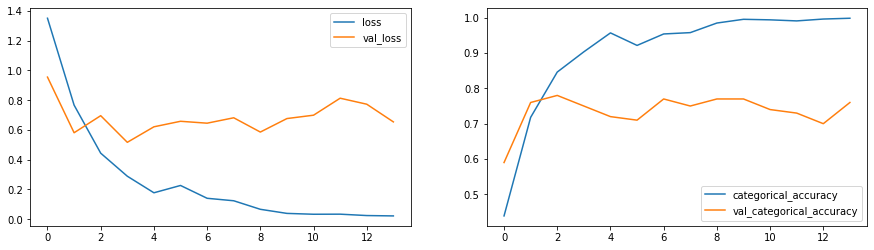

In [20]:
image_height = 120
image_width = 120
channels=3
num_classes=5
total_frames=30
frames_to_sample=15
batch_size=20
num_epochs=20

tf_1 = transfer_learning_model_1(lstm_cells=128,dense_neurons=128,dropout=0.25)
optimiser = Adam()
tf_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (tf_1.summary())
tf_1_history = train_model(tf_1, batch_size, total_frames, frames_to_sample,image_height,image_width, num_epochs, augment_data=True)
plot(tf_1_history)

As you can see that the validation accuracy is incresed but not enough. 

### MobileNet + GRU - Experiment 10

In [11]:
mobilenet_transfer.trainable = True

In [12]:
def transfer_learning_model_2(lstm_cells=64, dense_neurons=64, dropout=0.25):

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer, input_shape=(frames_to_sample, image_height, image_width, 3)))

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(lstm_cells))  # GRU layer instead of LSTM
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(5, activation='softmax'))

    return model  # Add a return statement to return the created model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)               4

/tmp/ipykernel_206/81854442.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20


2024-07-03 01:02:49.235657: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.1052 - categorical_accuracy: 0.5611
Epoch 00001: val_loss improved from inf to 0.68548, saving model to model_init_2024-07-0301_02_43.052680/model-00001-1.10519-0.56109-0.68548-0.67000.h5
67/67 [==============================] - 167s 2s/step - loss: 1.1052 - categorical_accuracy: 0.5611 - val_loss: 0.6855 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.4410 - categorical_accuracy: 0.8288
Epoch 00002: val_loss improved from 0.68548 to 0.40592, saving model to model_init_2024-07-0301_02_43.052680/model-00002-0.44098-0.82881-0.40592-0.84000.h5
67/67 [==============================] - 149s 2s/step - loss: 0.4410 - categorical_accuracy: 0.8288 - val_loss: 0.4059 - val_categorical_accuracy: 0.8400 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.3324 - categorical_accuracy: 0.8884
Epoch 00003: val_loss did not improve from 0.40592


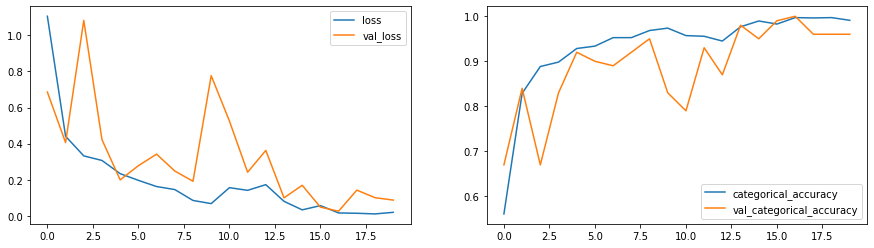

In [13]:
image_height = 120
image_width = 120
channels=3
num_classes=5
total_frames=30
frames_to_sample=15
batch_size=10
num_epochs=20

tf_2 = transfer_learning_model_2(lstm_cells=128,dense_neurons=128,dropout=0.25)
optimiser = Adam()
tf_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (tf_2.summary())
tf_2_history = train_model(tf_2, batch_size, total_frames, frames_to_sample,image_height,image_width, num_epochs, augment_data=True)
plot(tf_2_history)

This model has 100% validation accuracy and validation loss is almost 0 and classified all the images correctly. So we can say it is not overfitting.

## Final Model

#### After doing all the experiments, we finalize the model created in Experiment 10 (MobileNet + GRU) which performed well.
-  loss: 0.0164
-  val_loss: 0.0263
-  categorical_accuracy: 0.99
-  val_categorical_accuracy: 1.00